# CS 190H/292H Midterm
### Approximating the Sigmoid activation function by way of transition probability response function
Firstly, it's important we define some basic functions. We need not implement a circuit just yet, as we can model everything as some basic matrix multiplication functions. <br>
We need to make:
1. A rotation gate
2. A unitary as a composite of equiangular rotation gates
3. The transition probability response function itself

In [3]:
import numpy as np
from typing import List
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [4]:
# A basic rotation operator, generally fix theta
def R(phi: float, theta: float):
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([ [0, -1j], [1j, 0] ])
    return expm(-1j * theta / 2 * (np.cos(phi)*X + np.sin(phi)*Y))

print(R(np.pi / 2, np.pi / 2))

[[ 0.70710678+3.08148791e-33j -0.70710678-4.32978028e-17j]
 [ 0.70710678-4.32978028e-17j  0.70710678+0.00000000e+00j]]


In [5]:
# vphi -> list of phi_1, phi_2, ..., etc
def eqang_U(vphi: List[float], theta: float):
    U = np.array([[1.+0.j, 0.+0.j], [0.+0.j, 1.+0.j]])
    for phi in vphi:
        U = U @ R(phi, theta)
    return U

print(eqang_U([np.pi/2], np.pi/2))

[[ 0.70710678+3.08148791e-33j -0.70710678-4.32978028e-17j]
 [ 0.70710678-4.32978028e-17j  0.70710678+0.00000000e+00j]]


Text(0, 0.5, '$f_{\\vec{\\phi}}(\\theta)$')

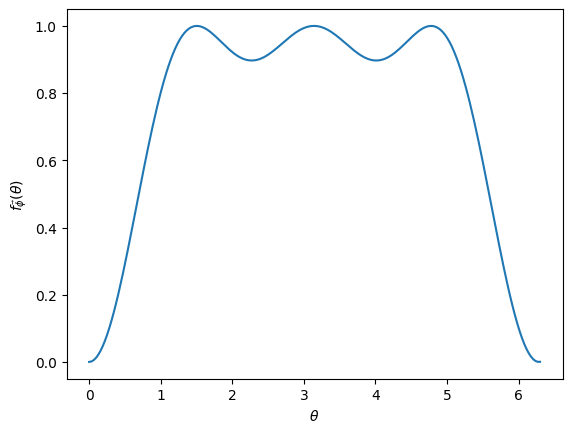

In [ ]:
#Transition response function
# Want to find a vphi s.t. tprf(vphi, theta) ~= sigmoid(theta)
def tprf(vphi: List[float], theta: float):
    ket0, ket1 = np.array([1, 0]), np.array([0,1])
    return np.pow(np.abs(ket0.transpose().conj() @ ((eqang_U(vphi, theta)) @ ket1) ), 2)

x = np.linspace(0, 6.3, 200)
y = [tprf([0, 1.5, 0], theta) for theta in x]
plt.plot(x, y)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$f_{\vec{\phi}}(\theta)$')

We now have a way to plot and track the probability response function $f_{\vec{\phi}}(\theta)=|\bra{0} R_{\phi_0}(\theta)R_{\phi_1}(\theta)\cdots R_{\phi_N}(\theta)\ket{1}|^2$ and functions to return corresponding unitaries for both the composite gate and the individual equiangular gates.
# Modelling the Sigmoid
### Straight-forward approach - let $L$ be as large as we need it to be
Following the routine given in [https://arxiv.org/pdf/2002.11649](https://arxiv.org/pdf/2002.11649), we will see how this algorithim pans, since the point is to have speedup over the Remez algorithim. We first need:

In [ ]:
def qinfo_generator(phiset: List[float]):
    phiinfo = {}
    phiinfo["d"] = len(phiset)
    phiinfo["d_"] = int((phiinfo["d"] + 1) / 2 + 0.5)
    phiinfo["cheb_roots"] = [np.cos((2*i - 1)*np.pi / (4*phiinfo["d_"])) for i in range(1, phiinfo["d_"] + 1)]
    phiinfo["phiset"] = phiset
    phiinfo["phihat"] = phiset[:phiinfo["d_"]]
    phiinfo["Phi"] = phiinfo["phihat"] + reversed(phiinfo["phihat"]) if phiinfo["d"] % 2 == 1 else phiinfo["phihat"]+reversed(phiinfo["phihat"])[1:]

def QSPBFGS(phihat_0: List[float], func, tolerance: float):
    master = qinfo_generator(phihat_0)
    objective_func = lambda qinfo: (1 / qinfo["d_"])*sum([ np.abs(tprf(qinfo["Phi"], qinfo["cheb_roots"][i-1]) - func(qinfo["cheb_roots"][i-1]) )**2 for i in range(1, qinfo["d_"]) ])
